In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('final_dataset.csv')
df.head()  

,Rating,Name,Symbol,Rating Agency Name,Date,Sector,currentRatio,quickRatio,cashRatio,daysOfSalesOutstanding,...,operatingCashFlowSalesRatio,payablesTurnover,Negative,Positive,Uncertainty,Litigious,Strong_Modal,Weak_Modal,Constraining,Readability
0,A,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,11/27/2015,Consumer Durables,0.945894,0.426395,0.099690,44.203245,...,0.058638,3.906655,1.514332,1.045610,1.820804,1.225888,0.216333,0.450694,0.946458,10.72
1,BBB,Whirlpool Corporation,WHR,Egan-Jones Ratings Company,2/13/2014,Consumer Durables,1.033559,0.498234,0.203120,38.991156,...,0.067239,4.002846,2.379140,0.875523,1.617815,1.427484,0.209364,0.399695,0.590027,10.31
2,BBB,Whirlpool Corporation,WHR,Fitch Ratings,03-06-2015,Consumer Durables,0.963703,0.451505,0.122099,50.841385,...,0.074426,3.483510,2.555911,0.778754,1.757188,1.357827,0.139776,0.399361,0.459265,10.48
3,BBB,Whirlpool Corporation,WHR,Fitch Ratings,6/15/2012,Consumer Durables,1.019851,0.510402,0.176116,41.161738,...,0.028394,4.581150,2.580837,1.275586,1.483239,1.216256,0.148324,0.355977,0.504301,11.19
4,BBB,Whirlpool Corporation,WHR,Standard & Poor's Ratings Services,10/24/2016,Consumer Durables,0.957844,0.495432,0.141608,47.761126,...,0.058065,3.857790,1.231846,1.154046,2.035788,0.635373,0.207469,0.414938,0.920643,11.21


In [2]:
df['Rating'] = df['Rating'].apply(lambda x: 1 if x in ['AAA', 'BBB', 'AA', 'A'] else 0)

In [3]:
import numpy as np
np.unique(df["Rating"])

array([0, 1], dtype=int64)

In [4]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Sector'] = label_encoder.fit_transform(df['Sector'])

label_encoder2 = LabelEncoder()
df['Symbol'] = label_encoder.fit_transform(df['Symbol'])


In [5]:
df.drop(["Name" , "Date" , "Rating Agency Name"] , axis = 1 , inplace = True)

In [6]:
columns_to_standardize = df.columns[1:]
scaler = StandardScaler()
df[columns_to_standardize] = scaler.fit_transform(df[columns_to_standardize])
df.to_csv('standardized_dataset.csv', index=False)

In [7]:
X = df.drop(["Rating"] , axis = 1)
y = df["Rating"]

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , accuracy_score

In [9]:
def stack_ensemble(X_train,X_test , y_train , y_test):
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Define base models
    base_models = [
        ("catboost", CatBoostClassifier(iterations=100, learning_rate=0.1, depth=6, verbose=False)),
        ("lightgbm", LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=6 , verbose = -1)),
        ("random_forest", RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42))
    ]

    stack_train = np.zeros((X_train.shape[0], len(base_models)))
    stack_test = np.zeros((X_test.shape[0], len(base_models)))

    # Stratified K-Folds for base models
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Train each base model and store their predictions for stacking
    for i, (name, model) in enumerate(base_models):
        fold_train = np.zeros((X_train.shape[0],))  
        fold_test = np.zeros((X_test.shape[0], 5)) 

        for j, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
            # Split data using the indices provided by K-Fold
            X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
            y_fold_train, y_fold_val = y_train[train_idx], y_train[val_idx]

            # Fit the model on this fold
            model.fit(X_fold_train, y_fold_train)

            # Predict validation set (for stacking), flatten the predictions to avoid shape mismatch
            fold_train[val_idx] = model.predict(X_fold_val).ravel()

            fold_test[:, j] = model.predict(X_test).ravel()

        stack_train[:, i] = fold_train
        stack_test[:, i] = fold_test.mean(axis=1)

    stacker = LogisticRegression()
    stacker.fit(stack_train, y_train)

    final_predictions = stacker.predict(stack_test)
    return confusion_matrix(y_test, final_predictions)

In [14]:

def xgboost(X_train,X_test , y_train , y_test):
    xgboost_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, use_label_encoder=False, eval_metric='mlogloss')
    xgboost_model.fit(X_train, y_train)
    y_pred_xgboost = xgboost_model.predict(X_test)
    return confusion_matrix(y_test, y_pred_xgboost)

c:\Users\aaditya\Desktop\aaditya\ml-dl\ml_project_1\Performance_Prediction\proj_env\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\aaditya\Desktop\aaditya\ml-dl\ml_project_1\Performance_Prediction\proj_env\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\aaditya\Desktop\aaditya\ml-dl\ml_project_1\Performance_Prediction\proj_env\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\aaditya\Desktop\aaditya\ml-dl\ml_project_1\Performance_Prediction\proj_env\lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
c:\Users\aaditya\Desktop\aaditya\ml-dl\ml_project_1\Performance_

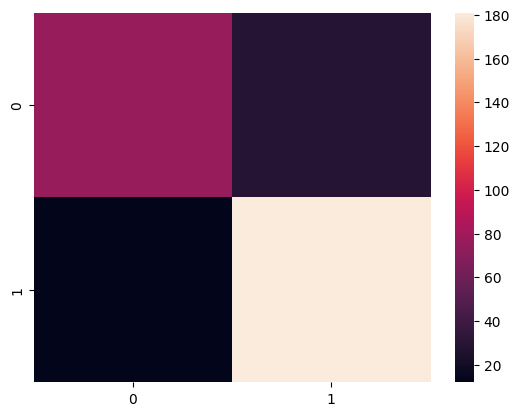

In [18]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def run_model1(X,y):
    X_train,X_test , y_train , y_test = train_test_split(X,y , test_size = 0.2 , random_state = 42)
    sns.heatmap(stack_ensemble(X_train,X_test , y_train , y_test))


def run_model2(X,y):
    X_train,X_test , y_train , y_test = train_test_split(X,y , test_size = 0.2 , random_state = 42)
    sns.heatmap(xgboost(X_train,X_test , y_train , y_test))

run_model(X,y) 

In [ ]:
X = X.drop(["Negative","Positive","Uncertainty","Litigious","Strong_Modal","Weak_Modal","Constraining","Readability"] ,axis = 1)
run_model(X ,y)   # no nlp extracted features used 
